---
### *The 12th Computational Neuroscience Winter School*

# Tutorial II: Neuron software
---
__Date:__ Jan. 13, 2023

__Content Creator:__ Jingyang Ma, Ziling Wang, Kai Chen, Songting Li

# Tutorial Objectives

In this notebook, we'll learn how to use the Neuron software in python to build the biophysical neuron(or neuronal network) and do some simulations as we like. There are 4 sections in this tutorial:

1. Simulation of  a point neuron
1. Simulation of neuron with dendtrites
1. Simulation of neuronal network
1. Simulation of a real neuron from ModelDB

#### References:
- https://www.neuron.yale.edu/neuron/static/py_doc/index.html
- https://neuronaldynamics.epfl.ch
- https://senselab.med.yale.edu/ModelDB/
- Li, S., Liu, N., Zhang, X., Zhou, D., Cai, D. (2014) Bilinearity in spatiotemporal integration of synaptic inputs. PLoS Comput Biol.
- Li, S., Liu, N., Zhang, X., McLaughlin, D. W., Zhou, D., & Cai, D. (2019). Dendritic computations captured by an effective point neuron model. Proceedings of the National Academy of Sciences.
- Hay E, Hill S, Schürmann F, Markram H, Segev I (2011) Models of Neocortical Layer 5b Pyramidal Cells Capturing a Wide Range of Dendritic and Perisomatic Active Properties. PLoS Comput Biol.

# Section 3: Simulation of neuronal network

In [1]:
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
h.load_file('stdrun.hoc')


--No graphics will be displayed.


1.0

## Step 1: connect the neurons via synapses

In [2]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend0 = h.Section(name='dend0', cell=self)
        self.all = [self.soma, self.dend0]                                     
        self.dend0.connect(self.soma(0))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite                       
        self.dend0.insert('pas')                                        
        for seg in self.dend0:                                         
            seg.pas.g = 0.001  # Passive conductance in S/cm2          
            seg.pas.e = -65    # Leak reversal potential mV            
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

Create N neurons using a list

In [3]:
neuron_num = 10
neurons = [BallAndStick(i) for i in range(neuron_num)]

In [4]:
neurons[0]

BallAndStick[0]

In [5]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
 `|       BallAndStick[0].dend0(0-1)
|-|       BallAndStick[1].soma(0-1)
 `|       BallAndStick[1].dend0(0-1)
|-|       BallAndStick[2].soma(0-1)
 `|       BallAndStick[2].dend0(0-1)
|-|       BallAndStick[3].soma(0-1)
 `|       BallAndStick[3].dend0(0-1)
|-|       BallAndStick[4].soma(0-1)
 `|       BallAndStick[4].dend0(0-1)
|-|       BallAndStick[5].soma(0-1)
 `|       BallAndStick[5].dend0(0-1)
|-|       BallAndStick[6].soma(0-1)
 `|       BallAndStick[6].dend0(0-1)
|-|       BallAndStick[7].soma(0-1)
 `|       BallAndStick[7].dend0(0-1)
|-|       BallAndStick[8].soma(0-1)
 `|       BallAndStick[8].dend0(0-1)
|-|       BallAndStick[9].soma(0-1)
 `|       BallAndStick[9].dend0(0-1)



1.0

### Synapse

Biologically, neurons are connected via synapses

![synapse](./pictures/synapse.png)

Mathematically, we are use the following model to build a synapse:
$$
I_{syn}=g_{syn}(t)(u(t)-E_{syn})
$$
$$
g_{syn}=\bar{g}_{syn}e^{(-(t-t^f)/\tau)}\Theta(t-t^f).
$$
or
$$
g_{syn}=\bar{g}_{syn}e^{(-(t-t^f)/\tau_1)}(1-e^{(-(t-t^f)/\tau_2)})\Theta(t-t^f).
$$
For inhibitory synapses $E_{syn}$ is usually set to −75 mV, whereas for excitatory synapses $E_{syn} \approx 0$. And $\tau$ is the time constant.

![synaptic_I](./pictures/synaptic_I.png)

Event-based communication between objects in NEURON takes place via network connection objects called **NetCon**. Each NetCon has a source and target, where the source is typically a spike threshold detector. When a spike is detected, the NetCon sends a message to a target, usually a synapse on a postsynaptic cell.

A **NetStim** is a spike generator that can be used as the source in a NetCon, behaving as external input onto the synapse of a target cell. The following code makes a NetStim object that generates one spike at time t=9. The NetCon then adds another ms delay to deliver a synaptic event at time t=10 onto the first cell.

The code below makes a stimulator and attaches it to a synapse object (**ExpSyn**) that behaves much like an AMPA synapse – it conducts current as a decaying exponential function.

In [6]:
stim = h.NetStim() # Make a new stimulator

# Attach it to a synapse in the middle of the dendrite
# of the first cell in the network. (Named 'syn_' to avoid
# being overwritten with the 'syn' var assigned later.)

syn_ = h.ExpSyn(neurons[0].dend0(0.5))

stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

Exponentially decaying currents, such as that generated by the synapse syn_ have dynamics that depend on tau, the time constant. Let's specify a time constant of 2 ms:

In [7]:
syn_.tau = 2 * ms

The parameter tau specifies how quickly the currents decay. The exact value of the current depends on the cell's membrane potential, and the synapse's reversal potential, syn_.e.

In [8]:
print('Reversal potential = {} mV'.format(syn_.e))

Reversal potential = 0.0 mV


# Step 2: Running and plotting a simulation

In [9]:
recording_cell = neurons[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend0(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [10]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

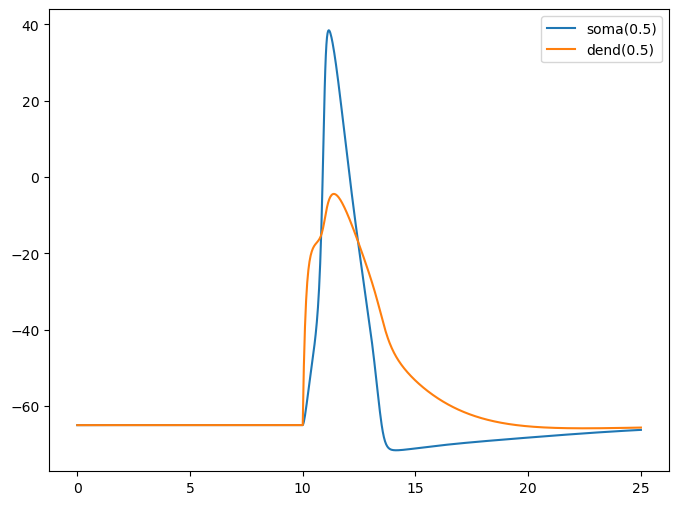

In [12]:
plt.figure(figsize=(8,6))
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

Change the excitatory synapse to an inhibitory one

In [13]:
syn_.e = -75 * mV

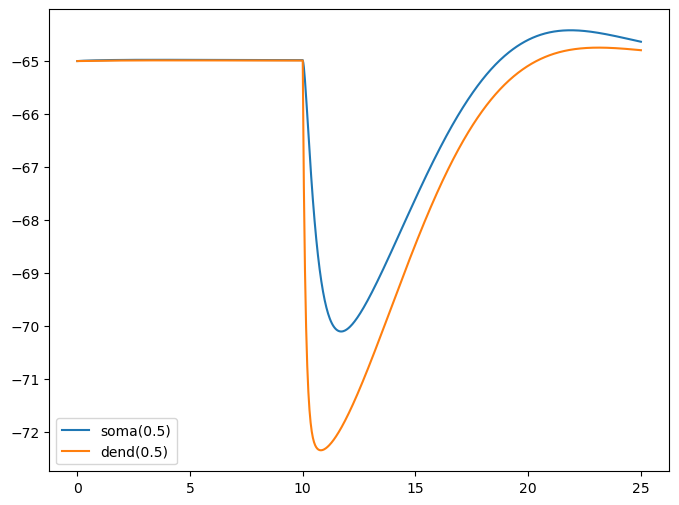

In [14]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

To understand the above graph, we may wish to consider the time series of synaptic current. Let's create a new Vector to monitor that:

In [15]:
syn_.e = 0 * mV
syn_i = h.Vector().record(syn_._ref_i)

In [16]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

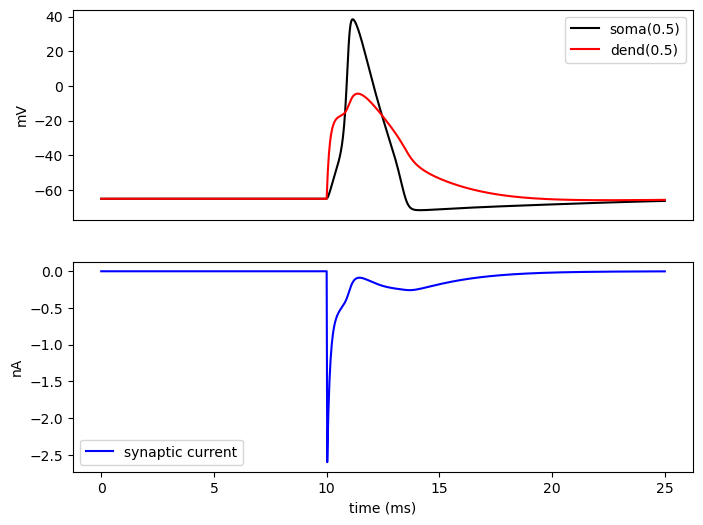

In [18]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2, 1, 1)
soma_plot = ax1.plot(t, soma_v, color='black', label='soma(0.5)')
dend_plot = ax1.plot(t, dend_v, color='red', label='dend(0.5)')
ax1.legend()
ax1.set_ylabel('mV')
ax1.set_xticks([]) # Use ax2's tick labels

ax2 = fig.add_subplot(2, 1, 2)
syn_plot = ax2.plot(t, syn_i, color='blue', label='synaptic current')
ax2.legend()
ax2.set_ylabel(h.units('ExpSyn.i'))
ax2.set_xlabel('time (ms)')
plt.show()

We can also the Netstim to generate inputs with uniform distribution or Poisson distribution

**stim.noise** is used to control the randomness of the inputs: 0 for uniform and 1 for Poisson. **stim.interval** is used to control the rate the inputs

In [19]:
stim.number = 10
stim.interval = 10
stim.start = 0
stim.noise = 0 # uniform
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

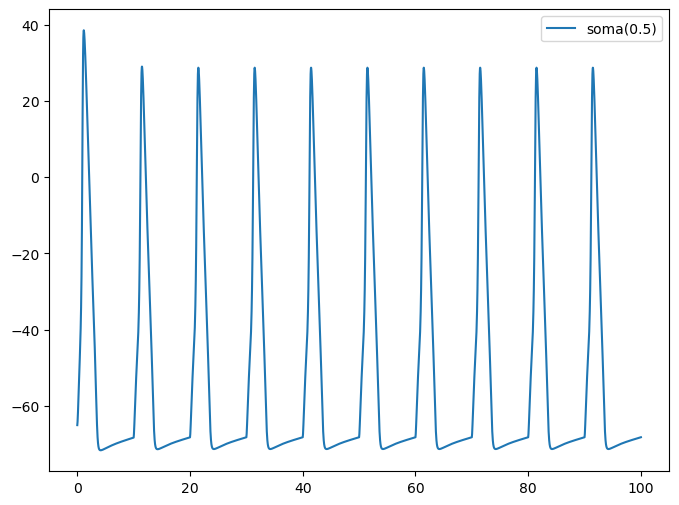

In [20]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, soma_v, label='soma(0.5)')
plt.legend()
plt.show()

In [21]:
stim.number = 10
stim.interval = 10
stim.start = 0
stim.noise = 1 # Poisson
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

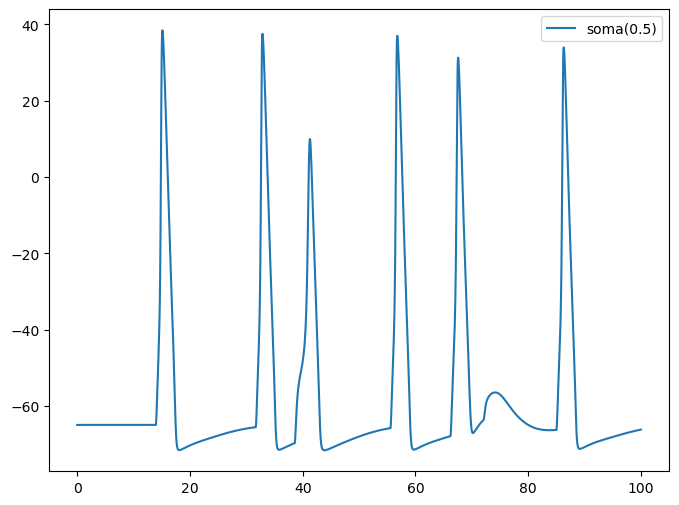

In [23]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, soma_v, label='soma(0.5)')
plt.legend()
plt.show()

### Use the NetCon to record the spike time

**NetCon = (source, target)**, The target is allowed to be None in which case the NetCon is always inactive. However this can be useful for recording the spike train from an output cell.

In [24]:
recording_cell = neurons[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend0(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [25]:
spike_time = h.Vector()
nc_re = h.NetCon(recording_cell.soma(0.5)._ref_v, None, sec=recording_cell.soma)
nc_re.record(spike_time)

0.0

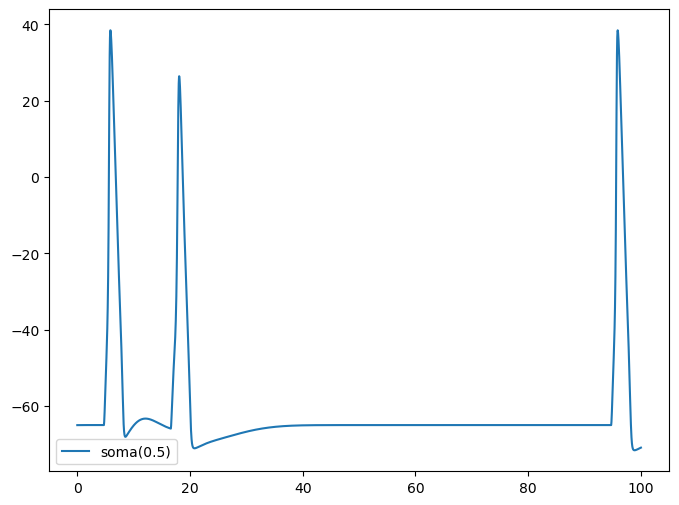

In [26]:
stim.number = 10
stim.interval = 10
stim.start = 0
stim.noise = 1 # Poisson
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, soma_v, label='soma(0.5)')
plt.legend()
plt.show()

In [28]:
print(np.array(spike_time))

[ 5.65  17.875 95.65 ]


## Step 3: Connecting the neurons

 Next, we need to connect an axon from cell n to a synapse at the middle of the dendrite on cell n + 1. For this model, the particular dynamics of the axons do not need to be explicitly modeled. When the soma fires an action potential, we assume the spike propagates down the axon and induces a synaptic event onto the dendrite of the target cell with some delay. We can therefore connect a spike detector in the soma of the presynaptic cell that triggers a synaptic event in the target cell via a NetCon.

In [29]:
syns = []
netcons = []
for source, target in zip(neurons, neurons[1:] + [neurons[0]]):
    syn = h.ExpSyn(target.dend0(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.weight[0] = 0.05
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

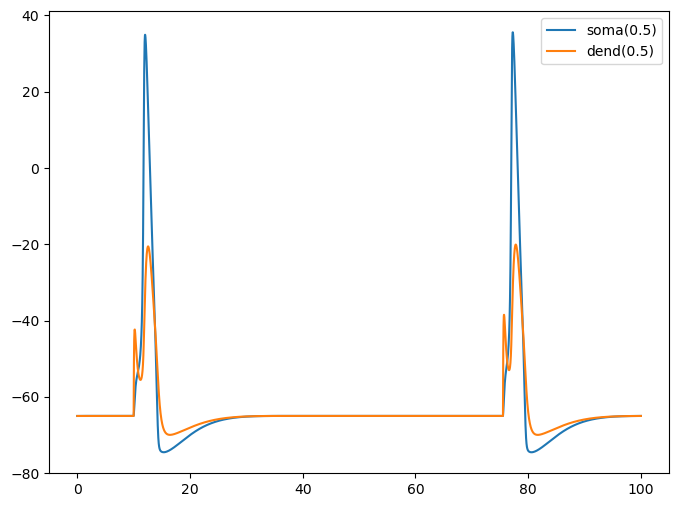

In [30]:
stim = h.NetStim() # Make a new stimulator
syn_ = h.ExpSyn(neurons[0].dend0(0.5))
stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.


h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

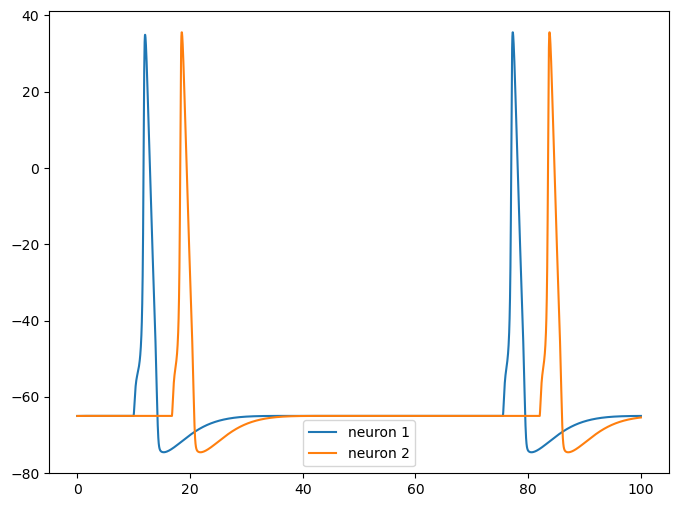

In [31]:
soma_v_1 = h.Vector().record(neurons[0].soma(0.5)._ref_v)
soma_v_2 = h.Vector().record(neurons[1].soma(0.5)._ref_v)
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, soma_v_1, label='neuron 1')
plt.plot(t, soma_v_2, label='neuron 2')
plt.legend()
plt.show()

## Step 4: Use netcon to record the spike time 

In [32]:
spike_times = [h.Vector() for nc in netcons]
for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)

In [33]:
stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.
h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

In [34]:
for i, spike_times_vec in enumerate(spike_times):
    print('cell {}: {}'.format(i, list(spike_times_vec)))

cell 0: [11.800000000099864, 77.05000000010895]
cell 1: [18.325000000099493, 83.57500000011044]
cell 2: [24.850000000099122, 90.10000000011192]
cell 3: [31.37500000009875, 96.6250000001134]
cell 4: [37.90000000010006]
cell 5: [44.42500000010154]
cell 6: [50.950000000103024]
cell 7: [57.47500000010451]
cell 8: [64.00000000010598]
cell 9: [70.52500000010747]


A more intuitive way of seeing this is to use a raster plot. Here's how to do that with matplotlib:

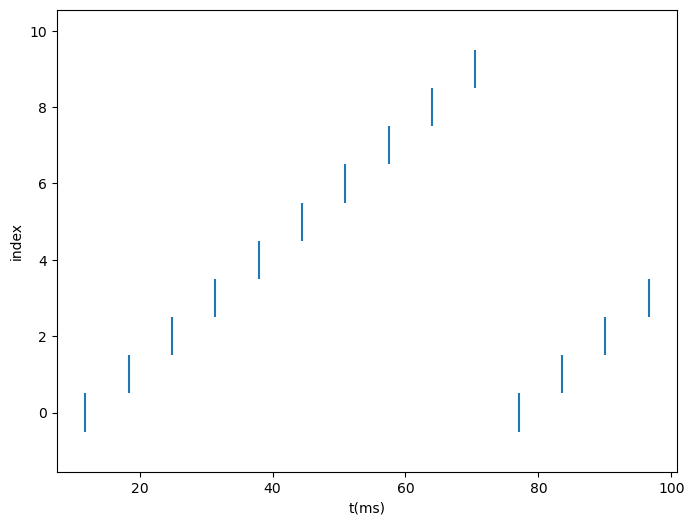

In [36]:
event = []
for spike_times_vec in spike_times:
    event.append(spike_times_vec)

plt.figure(figsize=(8,6))
plt.eventplot(event)
plt.xlabel('t(ms)')
plt.ylabel('index')
plt.show()

## Step 5: Build a larger neuronal network with random connection

In [37]:
neurons = []
neuron_num = 100
for i in range(neuron_num):
    neurons.append(BallAndStick(i))

Create a random connectivity matrix

In [38]:
connectivity_matrix = np.random.randint(0, 2, (neuron_num, neuron_num))
connectivity_matrix[np.eye(neuron_num, dtype=np.bool)] = 0

Connectivity matrix is a 0-1 matrix with size $N \times N$. The element $c_{ij}=1$ means there is a synatic connection from neuron j to neuron i.

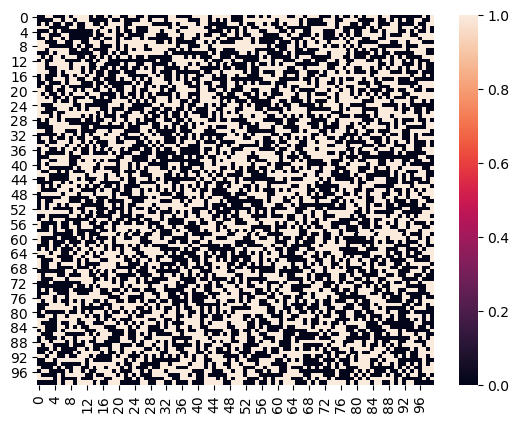

In [39]:
import seaborn as sns
sns.heatmap(connectivity_matrix)

In [40]:
syns = []
netcons = []
for i in range(neuron_num):
    for j in range(neuron_num):
        if connectivity_matrix[i][j] == 0:
            source = neurons[j]
            target = neurons[i]
            syn = h.ExpSyn(target.dend0(0.5))
            nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
            nc.weight[0] = 0.04
            nc.delay = 3
            netcons.append(nc)
            syns.append(syn)

In [43]:
spike_times = [h.Vector() for i in range(neuron_num)]
nc_res = [h.NetCon(neurons[i].soma(0.5)._ref_v, None, sec=neurons[i].soma) for i in range(neuron_num)]
for spike_time, nc_re in zip(spike_times, nc_res):
    nc_re.record(spike_time)

In [44]:
stim = h.NetStim() # Make a new stimulator
syn_ = h.ExpSyn(neurons[0].dend0(0.5))
stim.number = 1
stim.interval = 10
stim.start = 0
stim.noise = 0 
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

soma_v = h.Vector().record(neurons[0].soma(0.5)._ref_v)
soma_v_2 = h.Vector().record(neurons[1].soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

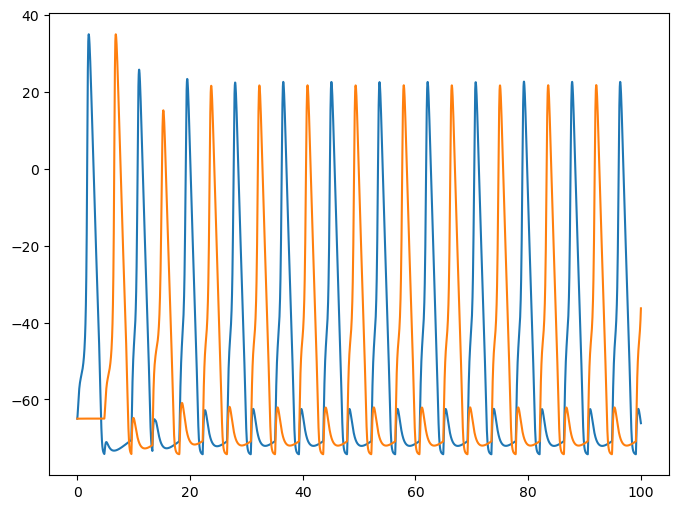

In [46]:
plt.figure(figsize=(8,6))
plt.plot(t, soma_v)
plt.plot(t, soma_v_2)

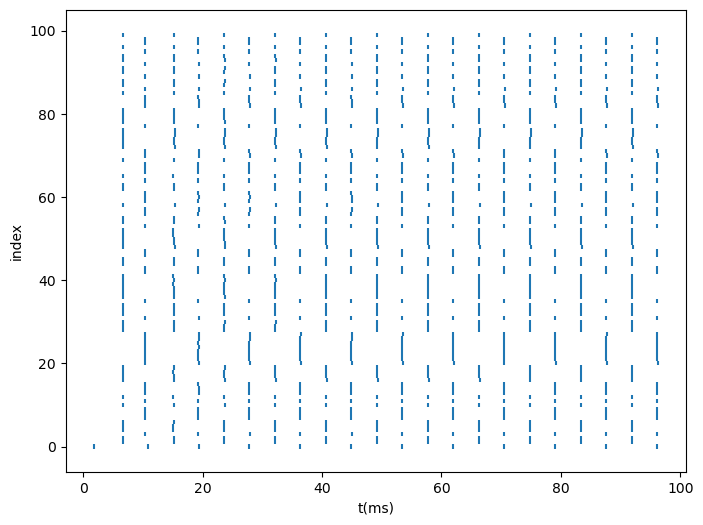

In [48]:
event = []
for spike_times_vec in spike_times:
    event.append(spike_times_vec)

plt.figure(figsize=(8,6))
plt.eventplot(event)
plt.xlabel('t(ms)')
plt.ylabel('index')
plt.show()

## Exercise3.1(Advanced): Can you infer the connectivity matrix from the spike train of all neurons?

## Exercise3.2(Advanced): What will happen if you change some of the excitatory synapses to inhibitory